In [1]:
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok = True)

URL = "https://github.com/pytorch/tutorials/raw/master/_static/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
  content = requests.get(URL + FILENAME).content
  (PATH / FILENAME).open("wb").write(content)


In [2]:
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
  ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

(50000, 784)


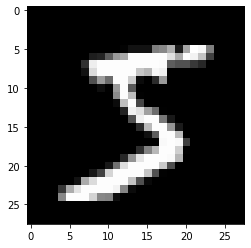

In [3]:
from matplotlib import pyplot
import numpy as np

pyplot.imshow(x_train[0].reshape((28, 28)), cmap="gray")
print(x_train.shape)

In [4]:
import torch
x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)

n, c = x_train.shape
print(x_train, y_train)
print(x_train.shape)
print(y_train.min(), y_train.max())

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
tensor(0) tensor(9)


In [5]:
import math

weights = torch.randn(784, 10) / math.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)

In [6]:
def log_softmax(x):
  return x - x.exp().sum(-1).log().unsqueeze(-1)

def model(xb):
  return log_softmax(xb @ weights + bias)

In [7]:
bs = 64

xb = x_train[0:bs]
preds = model(xb)
preds[0], preds.shape
print(preds[0], preds.shape)

tensor([-2.4122, -2.6465, -2.8791, -2.3724, -2.5196, -2.1748, -1.8930, -2.2190,
        -2.1959, -2.0769], grad_fn=<SelectBackward0>) torch.Size([64, 10])


In [8]:
# 손실 함수로 사용할 음수 로그 가능성 구현
def nll(input, target):
  return -input[range(target.shape[0]), target].mean()

loss_func = nll

In [9]:
yb = y_train[0:bs]
print(loss_func(preds, yb))

tensor(2.3018, grad_fn=<NegBackward0>)


In [10]:
# 모델의 정확도 계싼
def accuracy(out, yb):
  preds = torch.argmax(out, dim=1)
  return (preds == yb).float().mean()

In [11]:
print(accuracy(preds, yb))

tensor(0.1406)


In [22]:
from IPython.core.debugger import set_trace

lr = 0.5 # learning rate
epochs = 2 

for epoch in range(epochs):
  for i in range((n-1) // bs + 1):
    # set_trace()
    start_i = i * bs
    end_i = start_i + bs
    xb = x_train[start_i:end_i]
    yb = y_train[start_i:end_i]
    pred = model(xb)
    loss = loss_func(pred, yb)

    loss.backward()
    with torch.no_grad():
      weights -= weights.grad * lr
      bias -= bias.grad * lr
      weights.grad.zero_()
      bias.grad.zero_()

In [13]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0824, grad_fn=<NegBackward0>) tensor(1.)


In [14]:
import torch.nn.functional as F

loss_func = F.cross_entropy

def model(xb):
  return xb @ weights + bias

In [15]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0824, grad_fn=<NllLossBackward0>) tensor(1.)


# nn.Module을 이용하여 리팩터링

In [16]:
from torch import nn

class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(784, 10) / math.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(10))

    def forward(self, xb):
        return xb @ self.weights + self.bias

In [17]:
model = Mnist_Logistic()

In [18]:
print(loss_func(model(xb), yb))

tensor(2.3608, grad_fn=<NllLossBackward0>)


In [19]:
with torch.no_grad():
  weights -= weights.grad * lr
  bias -= bias.grad * lr
  weights.grad.zero_()
  bias.grad.zero_()

In [23]:
with torch.no_grad():
    for p in model.parameters(): p -= p.grad * lr
    model.zero_grad()

In [24]:
def fit():
  for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
      start_i = i * bs
      end_i = start_i + bs
      xb = x_train[start_i:end_i]
      yb = y_train[start_i:end_i]
      pred = model(xb)
      loss = loss_func(pred, yb)

      loss.backward()
      with torch.no_grad():
        for p in model.parameters():
            p -= p.grad * lr
        model.zero_grad()

fit()
                              

In [25]:
print(loss_func(model(xb), yb))

tensor(81.7477, grad_fn=<NllLossBackward0>)


In [26]:
class Mnist_Logistic(nn.Module):
  def __init__(self):
    super().__init__()
    self.lin = nn.Linear(784, 10)

  def forward(self, xb):
    return self.lin(xb)

In [27]:
model = Mnist_Logistic()
print(loss_func(model(xb), yb))

tensor(2.3487, grad_fn=<NllLossBackward0>)


In [28]:
fit()

print(loss_func(model(xb), yb))

tensor(0.0807, grad_fn=<NllLossBackward0>)


# nn.Linear를 사용하여 리팩터링

In [29]:
class Mnist_Logistic(nn.Module):
  def __init__(self):
    super().__init__()
    self.lin = nn.Linear(784, 10)

  def forward(self, xb):
    return self.lin(xb)

In [30]:
model = Mnist_Logistic()
print(loss_func(model(xb), yb))

tensor(2.2385, grad_fn=<NllLossBackward0>)


In [31]:
fit()

print(loss_func(model(xb), yb))

tensor(0.0816, grad_fn=<NllLossBackward0>)


# 최적화를 사용하여 리팩토링

In [32]:
with torch.no_grad():
  for p in model.parameters(): p -= p.grad * lr
  model.zero_grad()
  

In [33]:
from torch import optim

In [34]:
def get_model():
  model = Mnist_Logistic()
  return model, optim.SGD(model.parameters(), lr = lr)

model, opt = get_model()
print(loss_func(model(xb), yb))

for epoch in range(epochs):
  for i in range((n - 1) // bs + 1):
    start_i = i * bs
    end_i = start_i + bs
    xb = x_train[start_i:end_i]
    yb = y_train[start_i:end_i]
    pred = model(xb)
    loss = loss_func(pred, yb)

    loss.backward()
    opt.step()
    opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(2.2969, grad_fn=<NllLossBackward0>)
tensor(0.0820, grad_fn=<NllLossBackward0>)


# 데이터 세트를 사용하여 리팩터링
- 인덱싱의 길이와 방법을 정의함으로써 텐서의 첫번째 차원을 따라 반복
- 같은 줄에 있는 독립 변수와 종속 변수에 더 쉽게 액세스할 수 있음

In [35]:
from torch.utils.data import TensorDataset

In [36]:
train_ds = TensorDataset(x_train, y_train)

In [37]:
xb, yb = train_ds[i*bs : i*bs+bs]

In [38]:
model, opt = get_model()

for epoch in range(epochs):
  for i in range((n-1) // bs + 1):
    xb, yb = train_ds[i * bs : i * bs + bs]
    pred = model(xb)
    loss = loss_func(pred, yb)

    loss.backward()
    opt.step()
    opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(0.0805, grad_fn=<NllLossBackward0>)


# Data Loader를 통해 리팩터링

In [39]:
from torch.utils.data import DataLoader

train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size = bs)


In [40]:
for i in range((n-1)//bs + 1):
  xb, yb = train_ds[i*bs : i*bs + bs]
  pred = model(xb)

In [41]:
for xb, yb in train_dl:
  pred = model(xb)

In [42]:
model, opt = get_model()

for epoch in range(epochs):
  for xb, yb in train_dl:
    pred = model(xb)
    loss = loss_func(pred, yb)

    loss.backward()
    opt.step()
    opt.zero_grad()

print(loss_func(model(xb), yb))


tensor(0.0800, grad_fn=<NllLossBackward0>)


# 유효성 검사 추가

In [43]:
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size = bs, shuffle = True)

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size = bs * 2)

In [44]:
model, opt = get_model()

for epoch in range(epochs):
  model.train()
  for xb, yb in train_dl:
    pred = model(xb)
    loss = loss_func(pred, yb)

    loss.backward()
    opt.step()
    opt.zero_grad()

  model.eval()
  with torch.no_grad():
    valid_loss = sum(loss_func(model(xb), yb) for xb, yb in valid_dl)

  print(epoch, valid_loss / len(valid_dl))



0 tensor(0.3392)
1 tensor(0.2828)


# fit() 및 get_data() 생성
- loss_batch는 하나의 배치에 대한 손실 기록

In [45]:
def loss_batch(model, loss_func, xb, yb, opt=None):
  loss = loss_func(model(xb), yb)

  if opt is not None:
    loss.backward()
    opt.step()
    opt.zero_grad()

  return loss.item(), len(xb)

In [46]:
import numpy as np

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
  for epoch in range(epochs):
    model.train()
    for xb, yb in train_dl:
      loss_batch(model, loss_func, xb, yb, opt)

    model.eval()
    with torch.no_grad():
      losses, nums = zip(
          *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
      )
    val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

    print(epoch, val_loss)

In [47]:
def get_data(train_ds, valid_ds, bs):
  return (
      DataLoader(train_ds, batch_size = bs, shuffle = True),
      DataLoader(valid_ds, batch_size = bs * 2),
  )

In [48]:
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
model, opt = get_model()
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.299837804043293
1 0.3024059213399887


# CNN으로 전환

In [49]:
class Mnist_CNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 16, kernel_size = 3, stride=2, padding =1)
    self.conv2 = nn.Conv2d(16, 16, kernel_size = 3, stride=2, padding =1)
    self.conv3 = nn.Conv2d(16, 10, kernel_size = 3, stride=2, padding =1)

  def forward(self, xb):
    xb = xb.view(-1, 1, 28, 28)
    xb = F.relu(self.conv1(xb))
    xb = F.relu(self.conv2(xb))
    xb = F.relu(self.conv3(xb))
    xb = F.avg_pool2d(xb, 4)
    return xb.view(-1, xb.size(1))

lr = 0.1

In [50]:
model = Mnist_CNN()
opt = optim.SGD(model.parameters(), lr = lr, momentum=0.9)

fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.3529211129903793
1 0.2642727443695068


# nn.Sequential

In [51]:
class Lambda(nn.Module):
  def __init__(self, func):
    super().__init__()
    self.func = func

  def forward(self, x):
    return self.func(x)

def preprocess(x):
  return x.view(-1, 1, 28, 28)

In [52]:
model = nn.Sequential(
    Lambda(preprocess),
    nn.Conv2d(1, 16, kernel_size = 3, stride = 2, padding = 1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size = 3, stride = 2, padding = 1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size = 3, stride = 2, padding = 1),
    nn.ReLU(),
    nn.AvgPool2d(4),
    Lambda(lambda x: x.view(x.size(0), -1)),
)

opt = optim.SGD(model.parameters(), lr = lr, momentum=0.9)

fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.33102787766456604
1 0.23917299571037293


# DataLoader 래핑
- CNN은 상당히 간결하지만 다음과 같은 이유 때문에 MNIST에서만 작동
- 입력이 28 * 28 긴 벡터라고 가정
- 최종 CNN 그리드 크기가 4 * 4라고 가정


In [53]:
def preprocess(x, y):
  return x.view(-1, 1, 28, 28), y

class WrappedDataLoader:
  def __init__(self, dl, func):
    self.dl = dl
    self.func = func

  def __len__(self):
    return len(self.dl)

  def __iter__(self):
    batches = iter(self.dl)
    for b in batches:
      yield (self.func(*b))


train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)

In [54]:
model = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size = 3, stride = 2, padding = 1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size = 3, stride = 2, padding = 1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),
    Lambda(lambda x: x.view(x.size(0), -1)),
)

opt = optim.SGD(model.parameters(), lr = lr, momentum = 0.9)

In [55]:
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 1.4580256830215454
1 1.2329774203300476


In [56]:
print(torch.cuda.is_available())

True


In [57]:
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [58]:
def preprocess(x, y):
  return x.view(-1, 1, 28, 28).to(dev), y.to(dev)

train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)



In [59]:
model.to(dev)
opt = optim.SGD(model.parameters(), lr = lr, momentum = 0.9)

In [60]:
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 1.1030605341911315
1 1.079167077064514
